# RNN으로 이름 분류하기
https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import unicodedata
import string
import random
from time import time
import matplotlib.pyplot as plt

In [ ]:
all_letters = string.ascii_letters + " .,-"
n_letters = len(all_letters)

def utoa(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

def one_hot(s):
    tensor = torch.zeros(len(s), 1, n_letters)
    for i, c in enumerate(s):
        tensor[i][0][all_letters.find(c)] = 1
    return tensor

def load_name_data(path):
    # path = "./data/names/"
    data = {}
    for i, j in enumerate(os.listdir(path)):
        with open(path + j, "r") as f:
            key = j[:-4]
            data[key] = [utoa(s) for s in f.read().split()]
    label = list(data.keys())
    return data, label

def random_sample(data, label):
    key = random.choice(label)
    y = torch.tensor([label.index(key)], dtype=torch.long)
    item = random.choice(data[key])
    x = one_hot(item)
    return x, item, y, key

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
data, label = load_name_data("../data/names/")
data.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [99]:
x, item, y, key = random_sample(data, label)
item, key

('Arreola', 'Spanish')

In [110]:
n_hidden = 128
n_output = len(data.keys())
rnn = RNN(n_letters, n_hidden, n_output)

criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)
n_iters = 100000
plot_every = 5000

n_output

18

In [111]:
all_losses = []
cur_loss = 0
start_time = time()

for iter in range(1, n_iters + 1):
    x, item, y, key = random_sample(data, label)
    optimizer.zero_grad()
    h = rnn.initHidden()
    for i in range(len(item)):
        out, h = rnn(x[i], h)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    cur_loss += loss.item()
    guess = label[out.argmax()]
    
    if iter % plot_every == 0:
        plot_loss = cur_loss / plot_every
        all_losses.append(plot_loss)
        cur_loss = 0
        print("%d %.4fs %.4f %s / %s %s" % (iter, time() - start_time, plot_loss, item, guess, '✓' if guess == key else f'✗ ({key})'))

5000 6.4672s 2.7819 Meeuwes / Greek ✗ (Dutch)
10000 13.8922s 2.3529 Youj / Korean ✓
15000 21.0864s 2.0826 Vuu / Vietnamese ✓
20000 28.2057s 1.8973 Bove / Czech ✗ (Italian)
25000 35.5467s 1.8005 Gorecki / Italian ✗ (Polish)
30000 42.4567s 1.7468 Kassab / Arabic ✓
35000 49.2846s 1.6878 Maneates / Portuguese ✗ (Greek)
40000 56.4945s 1.6008 Ghanem / Arabic ✓
45000 64.2270s 1.5414 Basurto / Portuguese ✓
50000 71.4503s 1.5330 Mersinias / Greek ✓
55000 78.3489s 1.4670 Shang / Chinese ✓
60000 85.2962s 1.4327 Paternoster / Dutch ✗ (French)
65000 92.1300s 1.4216 Mariani / Italian ✓
70000 98.9430s 1.4064 Jamieson / Scottish ✓
75000 105.7614s 1.3645 Black / Scottish ✓
80000 113.2107s 1.3766 Wileman / Irish ✗ (English)
85000 120.6100s 1.3456 Chweh / Korean ✓
90000 127.6051s 1.3681 Lam / Vietnamese ✓
95000 134.6949s 1.3516 Arena / Spanish ✗ (Italian)
100000 141.8637s 1.3303 Galdin / Irish ✗ (Russian)


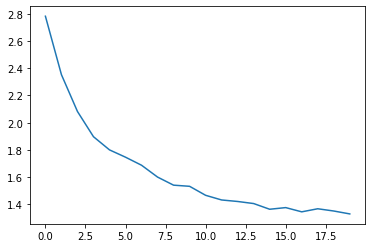

In [112]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [117]:
def print_pred(name, n_pred=3):
    print(f"> {name}")
    onehot = one_hot(name)
    h = rnn.initHidden()
    for i in range(len(name)):
        out, h = rnn(onehot[i], h)
    topv, topi = out.topk(n_pred, 1, True)
    for i in range(n_pred):
        print("(%.2f) %s" % (topv[0][i].item(), label[topi[0][i].item()]))

In [176]:
print_pred("Ibrahimovic")

> Ibrahimovic
(-0.36) Irish
(-2.90) Russian
(-3.11) French


In [161]:
data["Russian"]

['Ababko',
 'Abaev',
 'Abagyan',
 'Abaidulin',
 'Abaidullin',
 'Abaimoff',
 'Abaimov',
 'Abakeliya',
 'Abakovsky',
 'Abakshin',
 'Abakumoff',
 'Abakumov',
 'Abakumtsev',
 'Abakushin',
 'Abalakin',
 'Abalakoff',
 'Abalakov',
 'Abaleshev',
 'Abalihin',
 'Abalikhin',
 'Abalkin',
 'Abalmasoff',
 'Abalmasov',
 'Abaloff',
 'Abalov',
 'Abamelek',
 'Abanin',
 'Abankin',
 'Abarinoff',
 'Abarinov',
 'Abasheev',
 'Abashev',
 'Abashidze',
 'Abashin',
 'Abashkin',
 'Abasov',
 'Abatsiev',
 'Abaturoff',
 'Abaturov',
 'Abaza',
 'Abaziev',
 'Abbakumov',
 'Abbakumovsky',
 'Abbasov',
 'Abdank-Kossovsky',
 'Abdeev',
 'Abdildin',
 'Abdrahimoff',
 'Abdrahimov',
 'Abdrahmanoff',
 'Abdrahmanov',
 'Abdrakhimoff',
 'Abdrakhimov',
 'Abdrakhmanoff',
 'Abdrakhmanov',
 'Abdrashitoff',
 'Abdrashitov',
 'Abdrazakoff',
 'Abdrazakov',
 'Abdulaev',
 'Abdulatipoff',
 'Abdulatipov',
 'Abdulazizoff',
 'Abdulazizov',
 'Abdulbasiroff',
 'Abdulbasirov',
 'Abdulbekoff',
 'Abdulbekov',
 'Abdulgapuroff',
 'Abdulgapurov',
 'Abdul